In [2]:
import numpy as np
import pandas as pd
import ipdb
import pickle
import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm, multivariate_normal
from scipy.integrate import simps
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from scipy.special import expit, logit

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.ticker import NullFormatter
import seaborn as sns

import math

import torch
import torch.nn as nn
from mdn_model import MDNPerceptron
from convolutional_mdn_model import ConvMDNPerceptron

# specify model
## prior: $\alpha \sim Unif[-\pi,\pi],\ \ P(\lambda=0.7)=1-P(\lambda=0.1)=0.9$
## simulator: binary image $x$ with displacement $\lambda$, angle $a|\alpha \sim 0.5Lap(\alpha, 0.05) + 0.5Lap(\alpha, 0.0005)$

# fit convolutional MDN using PyTorch

In [3]:
with open('all_output_CMDN_2021-02-07-04-06.pkl', 'rb') as handle:
    pis, mus, sigmas = pickle.load(handle)

In [12]:
pis

{2: tensor([[0.5250, 0.4750],
         [0.5272, 0.4728],
         [0.5279, 0.4721],
         ...,
         [0.5271, 0.4729],
         [0.4960, 0.5040],
         [0.5334, 0.4666]], requires_grad=True),
 3: tensor([[4.8351e-01, 5.0683e-01, 9.6557e-03],
         [4.7969e-01, 5.0150e-01, 1.8816e-02],
         [4.8535e-01, 5.0514e-01, 9.5120e-03],
         ...,
         [4.8228e-01, 5.0314e-01, 1.4577e-02],
         [5.0283e-01, 4.9717e-01, 1.5730e-08],
         [4.7234e-01, 5.2160e-01, 6.0610e-03]], requires_grad=True),
 4: tensor([[1.1561e-08, 4.8983e-01, 3.8192e-08, 5.1017e-01],
         [4.4455e-01, 2.3693e-02, 5.0642e-01, 2.5341e-02],
         [7.4758e-07, 4.8449e-01, 1.9537e-06, 5.1550e-01],
         ...,
         [8.0257e-03, 4.6639e-01, 1.2104e-02, 5.1348e-01],
         [4.9009e-01, 3.4614e-13, 5.0991e-01, 1.3394e-13],
         [5.3405e-01, 1.8880e-13, 4.6595e-01, 9.5194e-14]], requires_grad=True),
 5: tensor([[4.4763e-01, 2.4329e-03, 5.3364e-01, 1.2993e-02, 3.3025e-03],
         [4

In [13]:
mus

{2: tensor([[-2.2577,  0.8734],
         [-1.6092,  1.5111],
         [-2.0466,  1.0781],
         ...,
         [-1.7690,  1.3554],
         [-0.7909,  2.3235],
         [-0.9244,  2.1992]], requires_grad=True),
 3: tensor([[ 0.9210, -2.2339, -1.1663],
         [ 1.5340, -1.6110, -0.4355],
         [ 1.1078, -2.0384, -0.9228],
         ...,
         [ 1.3949, -1.7524, -0.5839],
         [ 2.3381, -0.8131, -1.4581],
         [ 2.2081, -0.9360, -0.7172]], requires_grad=True),
 4: tensor([[-1.0819,  0.9137,  1.4835, -2.2342],
         [-1.5908,  1.3582,  1.5503, -1.6117],
         [-1.3005,  1.1029,  1.3908, -2.0279],
         ...,
         [-1.5538,  1.3837,  1.4320, -1.7515],
         [-0.8021, -0.2394,  2.3387, -1.3306],
         [-0.9258, -0.1028,  2.2041, -1.2868]], requires_grad=True),
 5: tensor([[ 0.9210,  0.7455, -2.2384,  0.7078, -1.3273],
         [ 1.5385,  0.4693, -1.6001,  1.3865, -1.4316],
         [ 1.1079,  0.6916, -2.0254,  1.1354, -1.4422],
         ...,
         [ 1.3

In [14]:
sigmas

{2: tensor([[0.0698, 0.0689],
         [0.0751, 0.0735],
         [0.0681, 0.0647],
         ...,
         [0.0730, 0.0704],
         [0.0483, 0.0619],
         [0.0896, 0.0890]], requires_grad=True),
 3: tensor([[0.0660, 0.0687, 1.4291],
         [0.0633, 0.0591, 1.5325],
         [0.0643, 0.0643, 1.4499],
         ...,
         [0.0633, 0.0603, 1.5068],
         [0.0359, 0.0308, 0.7359],
         [0.0664, 0.0657, 1.2961]], requires_grad=True),
 4: tensor([[0.1091, 0.0704, 0.0687, 0.0678],
         [0.0773, 0.0747, 0.0651, 0.0469],
         [0.1038, 0.0714, 0.0689, 0.0657],
         ...,
         [0.0868, 0.0756, 0.0675, 0.0583],
         [0.0293, 0.0259, 0.0379, 0.0058],
         [0.0745, 0.0588, 0.0709, 0.0127]], requires_grad=True),
 5: tensor([[0.0647, 0.0135, 0.0668, 0.3049, 0.6920],
         [0.0633, 0.0112, 0.0577, 0.3032, 0.2561],
         [0.0620, 0.0113, 0.0651, 0.2631, 0.5046],
         ...,
         [0.0617, 0.0107, 0.0611, 0.2611, 0.3202],
         [0.0410, 0.0044, 0.0268

# compute KL loss

In [172]:
# obs samples (theta,x) from joint distribution --> theta as obs sample from posterior given x
# negative log likelihood (based on out pi, mu, sigma) of observed theta according to f(theta|x), averaged across samples
out_pi_data, out_sigma_data, out_mu_data = sess.run(get_mixture_coef(output), feed_dict={x: x_data})

In [204]:
def compute_neg_log_lik(theta, pis, sigmas, mus):
    assert(pis.shape[0] == sigmas.shape[0] == mus.shape[0])
    density = 0
    for j in range(pis.shape[0]):
        density += pis[j] * norm.pdf(x=theta, loc=mus[j], scale=sigmas[j])
    return -np.log(density)

In [205]:
all_neg_log_lik = [compute_neg_log_lik(theta_data[i], out_pi_data[i], out_sigma_data[i], out_mu_data[i])
                   for i in range(NSAMPLE)]

In [214]:
# this is the KL loss for this model on obs data (up to additive constant)
1/NSAMPLE * sum(all_neg_log_lik)[0]

0.8195358647707888

# compute PIT values

In [219]:
def compute_mixture_pdf(theta, pis, sigmas, mus):
    assert(pis.shape[0] == sigmas.shape[0] == mus.shape[0])
    density = 0
    for j in range(pis.shape[0]):
        density += pis[j] * norm.pdf(x=theta, loc=mus[j], scale=sigmas[j])
    return density

In [265]:
# for each observed data point, calc pdf value (based on out pi, mu, sigma) of theta across a theta grid
theta_grid = np.linspace(-15, 15, 301)
# nested list comprehension ftw
all_pdf_values_data = np.array([[compute_mixture_pdf(theta_grid[t], out_pi_data[i], out_sigma_data[i], out_mu_data[i])
                                 for t in range(len(theta_grid))] for i in range(len(theta_data))])

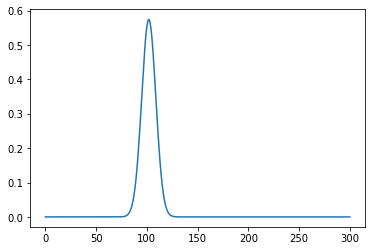

In [266]:
plt.plot(all_pdf_values_data[0])

In [267]:
den_integral = simps(all_pdf_values_data[0, :], x=theta_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

Integral of the first density integrates to: 1.00


In [268]:
# obs samples (theta,x) from joint distribution --> theta as obs posterior sample given x
pit_values = cdf_coverage(all_pdf_values_data, theta_grid, theta_data)

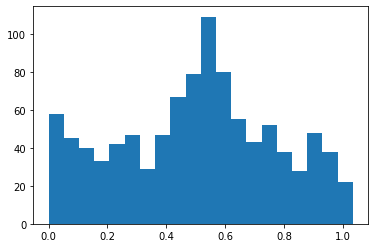

In [273]:
plt.hist(pit_values, bins=20)
plt.show()

In [ ]:
# need to tune KMIX from 2,3,...,10 and pick the one with the lowest KL loss
# then, compute PIT values for the "best" model and run our local diagnostics
# hopefully, we can (1) see it's not a good fit globally, (2) identify local areas where the fit is not good

# for confidence sets

In [623]:
def get_confidence_band_range(n_trials=100, name='x1x2', alpha=0.05, points=[[1,2]]):
    sample = [1 - all_rhat_classifiers[i][name][alpha].predict_proba(points)[:, 1][0] for i in range(n_trials)]
    return [min(sample), max(sample)]

# fixed $\alpha$, coverage heatmap

In [26]:
alpha = 0.2

In [27]:
x_range = np.linspace(-5,5,51)
x1, x2 = np.meshgrid(x_range, x_range)
grid = np.hstack([x1.ravel().reshape(-1,1), x2.ravel().reshape(-1,1)])
x_range_round = [round(x,1) for x in x_range]

In [32]:
ind_pit_values = [1*(x<=alpha) for x in pit_values]
ind_pit_values_x1 = [1*(x<=alpha) for x in pit_values_x1]
ind_pit_values_x2 = [1*(x<=alpha) for x in pit_values_x2]
ind_pit_values_marg = [1*(x<=alpha) for x in pit_values_marg]

In [33]:
rhat_alpha = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha.fit(X=x_test, y=ind_pit_values)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=25000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [34]:
rhat_alpha_x1 = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha_x1.fit(X=x_test, y=ind_pit_values_x1)

rhat_alpha_x2 = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha_x2.fit(X=x_test, y=ind_pit_values_x2)

rhat_alpha_marg = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha_marg.fit(X=x_test, y=ind_pit_values_marg)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=25000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [35]:
alpha_pred = rhat_alpha.predict_proba(grid)[:, 1]
alpha_pred_x1 = rhat_alpha_x1.predict_proba(grid)[:, 1]
alpha_pred_x2 = rhat_alpha_x2.predict_proba(grid)[:, 1]
alpha_pred_marg = rhat_alpha_marg.predict_proba(grid)[:, 1]

In [548]:
"""
X_test_logit = sm.add_constant(x_test)
grid_logit = sm.add_constant(grid)

rhat_logit = sm.Logit(endog=ind_pit_values, exog=X_test_logit).fit(disp=0)
rhat_logit_x1 = sm.Logit(endog=ind_pit_values_x1, exog=X_test_logit).fit(disp=0)
rhat_logit_x2 = sm.Logit(endog=ind_pit_values_x2, exog=X_test_logit).fit(disp=0)
rhat_logit_marg = sm.Logit(endog=ind_pit_values_marg, exog=X_test_logit).fit(disp=0)
"""

In [554]:
"""
alpha_logit_pred = rhat_logit.predict(grid_logit)
alpha_logit_pred_x1 = rhat_logit_x1.predict(grid_logit)
alpha_logit_pred_x2 = rhat_logit_x2.predict(grid_logit)
alpha_logit_pred_marg = rhat_logit_marg.predict(grid_logit)
"""

In [633]:
confidence_fixedalpha = {}
confidence_fixedalpha['x1x2'] = np.array([get_confidence_band_range(name='x1x2', alpha=alpha, points=[grid[i]])
                                          for i in range(len(grid))])
confidence_fixedalpha['x1'] = np.array([get_confidence_band_range(name='x1', alpha=alpha, points=[grid[i]])
                                        for i in range(len(grid))])
confidence_fixedalpha['x2'] = np.array([get_confidence_band_range(name='x2', alpha=alpha, points=[grid[i]])
                                        for i in range(len(grid))])
confidence_fixedalpha['marg'] = np.array([get_confidence_band_range(name='marg', alpha=alpha, points=[grid[i]])
                                          for i in range(len(grid))])

In [665]:
fixedalpha_within_null = {}
fixedalpha_within_null['x1x2'] = np.array([1 * (alpha_pred[i] < confidence_fixedalpha['x1x2'][i][0]
          or alpha_pred[i] > confidence_fixedalpha['x1x2'][i][1]) for i in range(len(alpha_pred))])
fixedalpha_within_null['x1'] = np.array([1 * (alpha_pred_x1[i] < confidence_fixedalpha['x1'][i][0]
          or alpha_pred_x1[i] > confidence_fixedalpha['x1'][i][1]) for i in range(len(alpha_pred))])
fixedalpha_within_null['x2'] = np.array([1 * (alpha_pred_x2[i] < confidence_fixedalpha['x2'][i][0]
          or alpha_pred_x2[i] > confidence_fixedalpha['x2'][i][1]) for i in range(len(alpha_pred))])
fixedalpha_within_null['marg'] = np.array([1 * (alpha_pred_marg[i] < confidence_fixedalpha['marg'][i][0]
          or alpha_pred_marg[i] > confidence_fixedalpha['marg'][i][1]) for i in range(len(alpha_pred))])

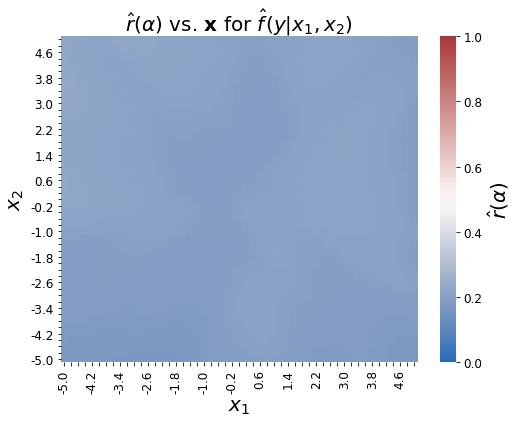

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

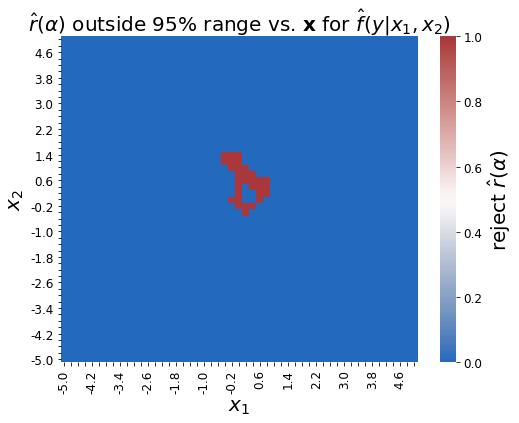

In [659]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['x1x2'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

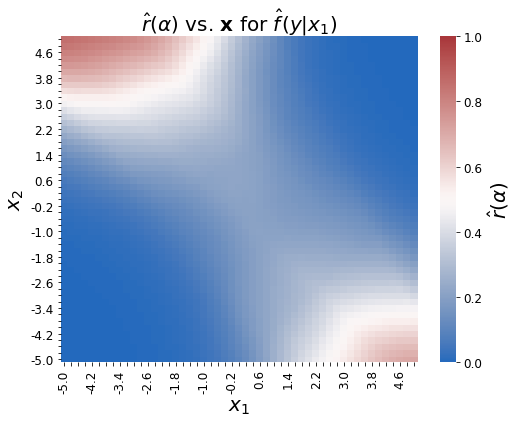

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred_x1.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

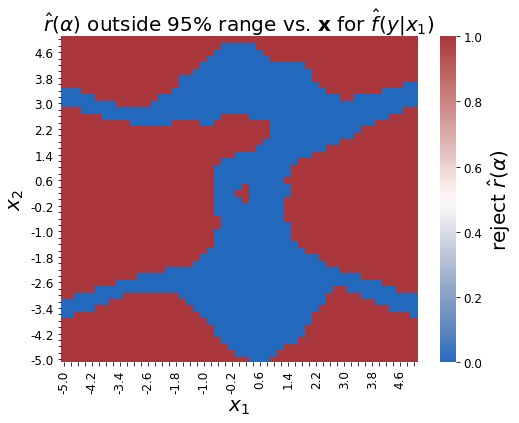

In [666]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['x1'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

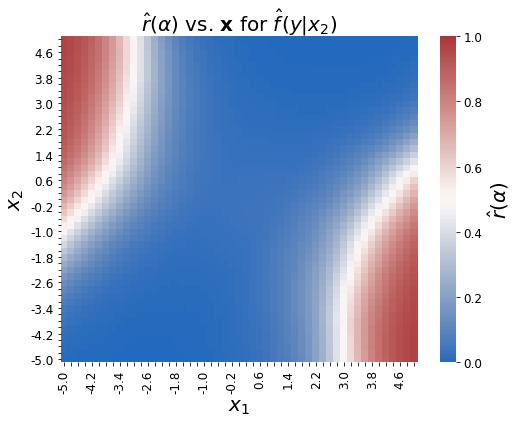

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred_x2.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

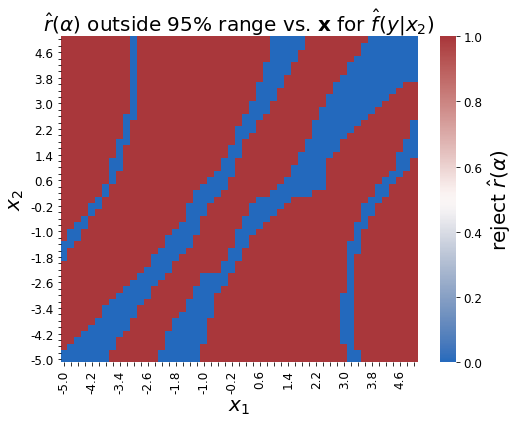

In [667]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['x2'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

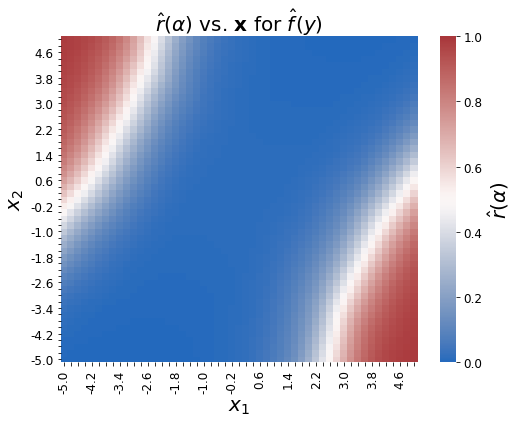

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred_marg.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

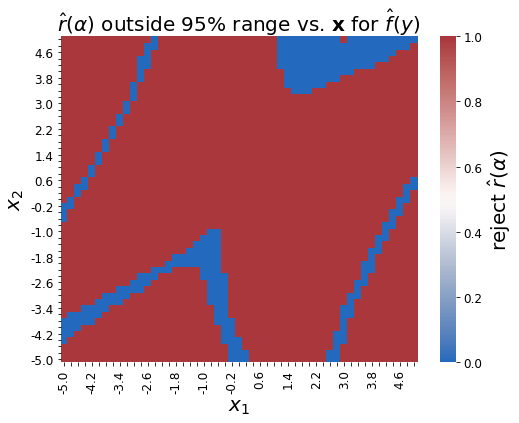

In [669]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['marg'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# fixed $\mathbf{x}_i$, QQ plot of $\hat r_\alpha(\mathbf{x}_i)$ vs. $\alpha$

In [40]:
x1 = 4
x2 = -4
points = np.array([[x1,x2]])
points_logit = np.array([[1,x1,x2]])

In [65]:
alphas = np.linspace(0.01, 0.99, 99)
pit_values_dict = {'x1x2': pit_values, 'x1': pit_values_x1, 'x2': pit_values_x2, 'marg': pit_values_marg}

In [66]:
rhat_alphas_xi = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    rhat_alphas_xi[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=x_test, y=ind_values)
        rhat_alphas_xi[name][alpha] = rhat.predict_proba(points)[:, 1][0]
rhat_alphas_xi = pd.DataFrame(rhat_alphas_xi)

working on classifier x1x2
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99
working on classifier x1
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999

In [542]:
"""
############# FOR CONFIDENCE INTERVALS #############

rhat_logit_alphas_xi = {}
rhat_logit_alphas_xi_se = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    rhat_logit_alphas_xi[name] = {}
    rhat_logit_alphas_xi_se[name] = {}
    
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat_logit = sm.Logit(endog=ind_values, exog=X_test_logit).fit(disp=0)
        pred = rhat_logit.predict(points_logit)[0]
        rhat_logit_alphas_xi[name][alpha] = pred
        
        # standard error
        rhat_logit_alphas_xi_se[name][alpha] = np.sqrt(np.array([xx@rhat_logit.cov_params()@xx for xx in points_logit]))[0]
        
rhat_logit_alphas_xi = pd.DataFrame(rhat_logit_alphas_xi)
rhat_logit_alphas_xi_se = pd.DataFrame(rhat_logit_alphas_xi_se)
"""

working on classifier x1x2
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier x1
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier x2
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier marg
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95


In [616]:
confidence_qqplot = {}
confidence_qqplot['x1x2'] = np.array([get_confidence_band_range(name='x1x2', alpha=i, points=points) for i in alphas])
confidence_qqplot['x1'] = np.array([get_confidence_band_range(name='x1', alpha=i, points=points) for i in alphas])
confidence_qqplot['x2'] = np.array([get_confidence_band_range(name='x2', alpha=i, points=points) for i in alphas])
confidence_qqplot['marg'] = np.array([get_confidence_band_range(name='marg', alpha=i, points=points) for i in alphas])

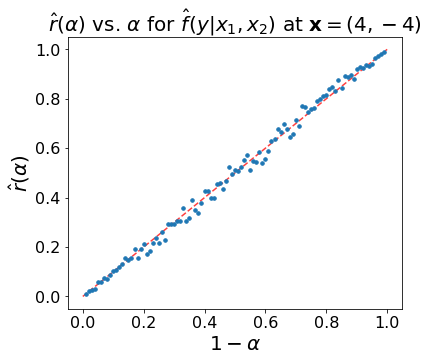

In [67]:
rhat_alphas_xi['x1x2'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['x1x2'].index,
                 confidence_qqplot['x1x2'][:, 0],
                 confidence_qqplot['x1x2'][:, 1],
                 alpha=0.15
                )
"""

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. " + r'$\alpha$' + " for $\hat f(y|x_1,x_2)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

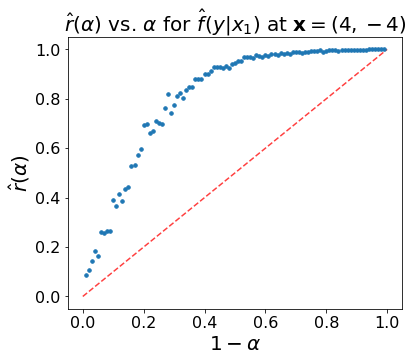

In [68]:
rhat_alphas_xi['x1'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['x1'].index,
                 confidence_qqplot['x1'][:, 0],
                 confidence_qqplot['x1'][:, 1],
                 alpha=0.15
                )
"""

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. " + r'$\alpha$' + " for $\hat f(y|x_1)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

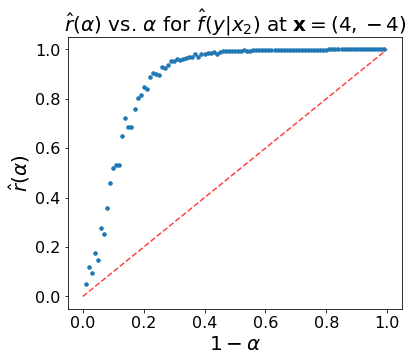

In [69]:
rhat_alphas_xi['x2'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['x2'].index,
                 confidence_qqplot['x2'][:, 0],
                 confidence_qqplot['x2'][:, 1],
                 alpha=0.15
                )
"""

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. " + r'$\alpha$' + " for $\hat f(y|x_2)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

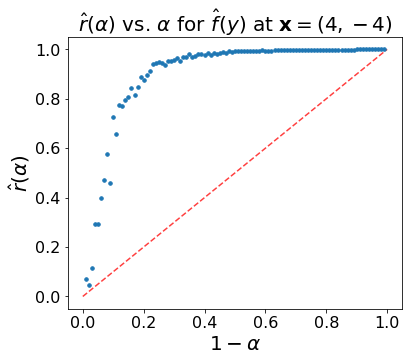

In [70]:
rhat_alphas_xi['marg'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['marg'].index,
                 confidence_qqplot['marg'][:, 0],
                 confidence_qqplot['marg'][:, 1],
                 alpha=0.15
                )
"""

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. " + r'$\alpha$' + " for $\hat f(y)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

In [76]:
#with open('rhat_alphas_xi_20210127.pkl', 'wb') as handle:
#    pickle.dump(rhat_alphas_xi, handle, protocol=pickle.HIGHEST_PROTOCOL)

# heat map of $T_i = \frac{1}{|G|} \sum_{\alpha \in G} (\hat r_\alpha(\mathbf{x}_i) - \alpha)^2$

In [71]:
Ti_values = {}
all_rhat_alphas = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    all_rhat_alphas[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=x_test, y=ind_values)
        
        # fit rhat at each point in prediction grid
        all_rhat_alphas[name][alpha] = rhat.predict_proba(grid)[:, 1]
        
    # rhat_alphas for all alphas at all points
    all_rhat_alphas[name] = pd.DataFrame(all_rhat_alphas[name])
    
    # compute Ti summary statistic
    Ti_values[name] = ((all_rhat_alphas[name] - alphas)**2).sum(axis=1) / len(alphas)

working on classifier x1x2
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99
working on classifier x1
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999

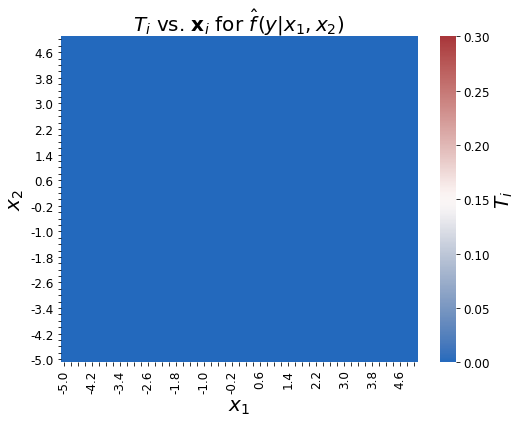

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x1x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

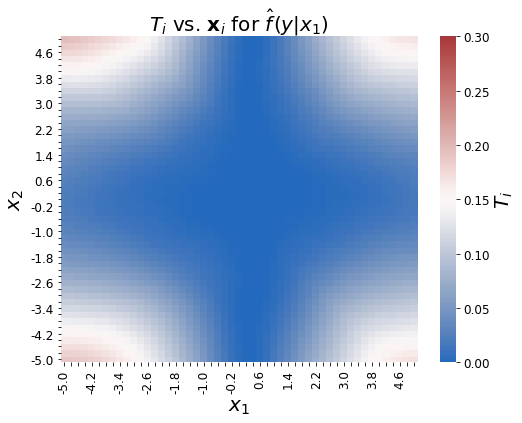

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x1'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

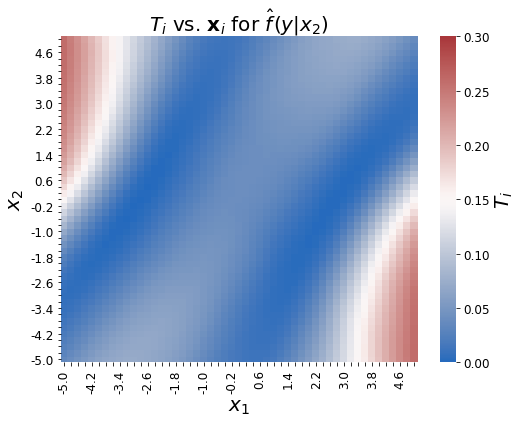

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

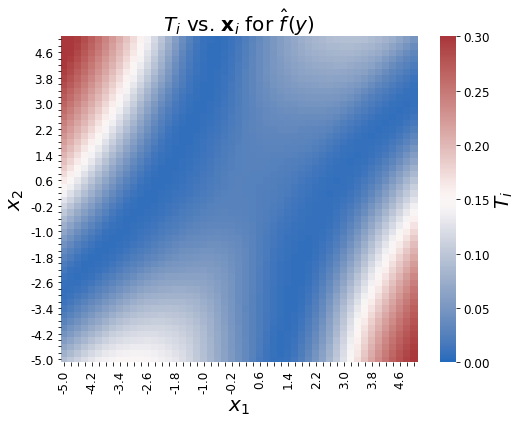

In [75]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['marg'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [78]:
#with open('Ti_values_20210127.pkl', 'wb') as handle:
#    pickle.dump(Ti_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

# global p-value based on $T_i$

In [462]:
global_pvalues = sum([1* (pd.DataFrame(true_Ti_values).mean() < pd.DataFrame(all_unif_Ti_values[i]).mean())
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
global_pvalues

x1x2    0.09
x1      0.00
x2      0.00
marg    0.00
dtype: float64

# local p-values based on $T_i$: local CvM test

In [63]:
#with open('pit_values_dict.pkl', 'wb') as handle:
#    pickle.dump(pit_values_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
#np.save('x_test.npy', x_test)

### saved $\hat r$ from MC samples, to build CIs

In [564]:
with open("all_rhat_classifiers_.pkl", 'rb') as handle:
    all_rhat_classifiers = pickle.load(handle)

C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [568]:
all_rhat_classifiers[0]['x1x2']

{0.05: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 0.1: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm

In [573]:
all_rhat_classifiers[0]['x1x2'][0.05].predict_proba([[1,2]])

array([[0.04379426, 0.95620574]])

In [328]:
with open("Ti_values.pkl", 'rb') as handle:
    true_Ti_values = pickle.load(handle)
with open("all_unif_Ti_values.pkl", 'rb') as handle:
    all_unif_Ti_values = pickle.load(handle)

In [352]:
all_pvalues = sum([1* (pd.DataFrame(true_Ti_values) < pd.DataFrame(all_unif_Ti_values[i]))
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
all_pvalues

,x1x2,x1,x2,marg
0,0.20,0.0,0.00,0.0
1,0.21,0.0,0.00,0.0
2,0.19,0.0,0.00,0.0
3,0.20,0.0,0.01,0.0
4,0.24,0.0,0.02,0.0
...,...,...,...,...
2596,0.14,0.0,0.08,0.0
2597,0.16,0.0,0.02,0.0
2598,0.18,0.0,0.00,0.0
2599,0.20,0.0,0.00,0.0


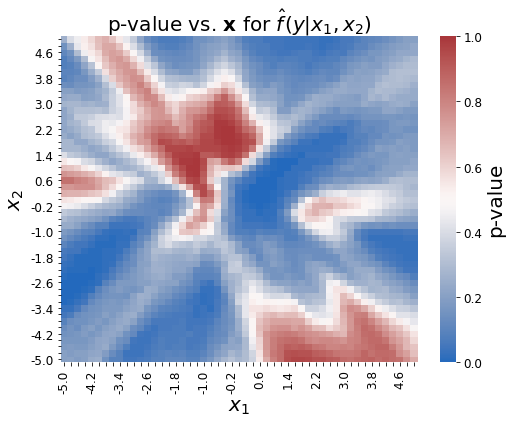

In [362]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x1x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

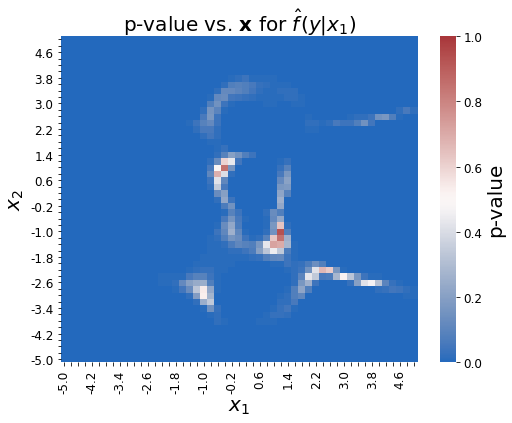

In [363]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x1'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

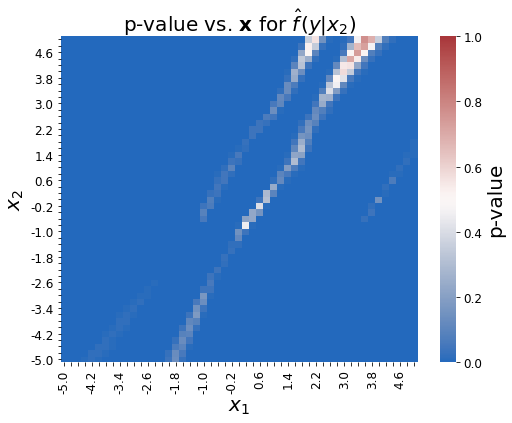

In [364]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

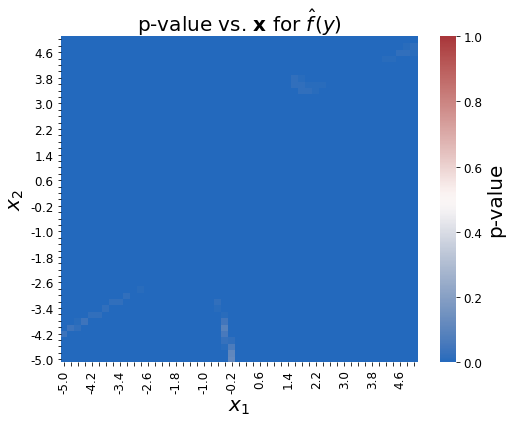

In [365]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['marg'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# Benjamini-Hochberg FDR correction

In [368]:
m = 51*51
alpha = 0.05

In [392]:
bh_values = alpha * (np.arange(m) + 1) / m

In [431]:
f_type = 'x1x2'
pval_vs_bh = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh.index
pval_vs_bh_sorted = pd.Series(pval_vs_bh.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_sorted == 1].index[-1]
bh_rejections = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                          index=use_idx)

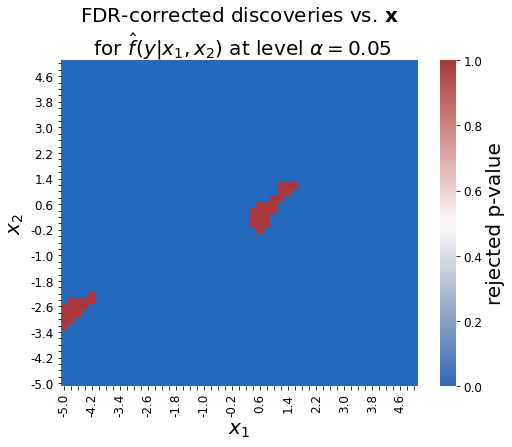

In [442]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_1,x_2)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [443]:
f_type = 'x1'
pval_vs_bh_x1 = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_x1.index
pval_vs_bh_x1_sorted = pd.Series(pval_vs_bh_x1.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_x1_sorted == 1].index[-1]
bh_rejections_x1 = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                             index=use_idx)

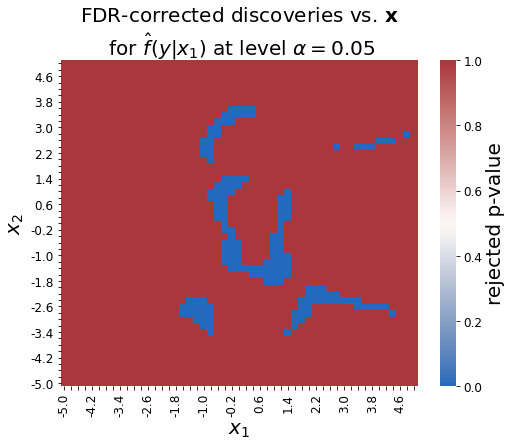

In [444]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_x1.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_1)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [446]:
f_type = 'x2'
pval_vs_bh_x2 = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_x2.index
pval_vs_bh_x2_sorted = pd.Series(pval_vs_bh_x2.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_x2_sorted == 1].index[-1]
bh_rejections_x2 = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                             index=use_idx)

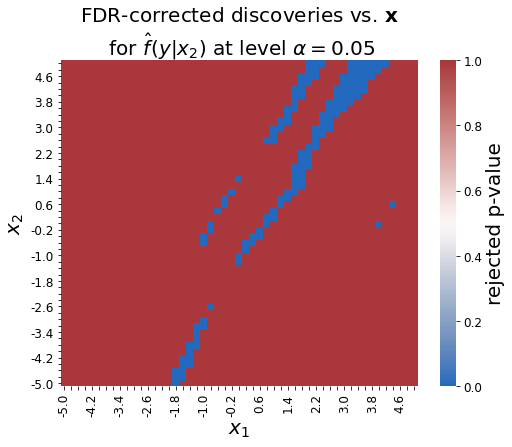

In [447]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_x2.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_2)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [449]:
f_type = 'marg'
pval_vs_bh_marg = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_marg.index
pval_vs_bh_marg_sorted = pd.Series(pval_vs_bh_marg.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_marg_sorted[pval_vs_bh_marg_sorted == 1].index[-1]
bh_rejections_marg = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                               index=use_idx)

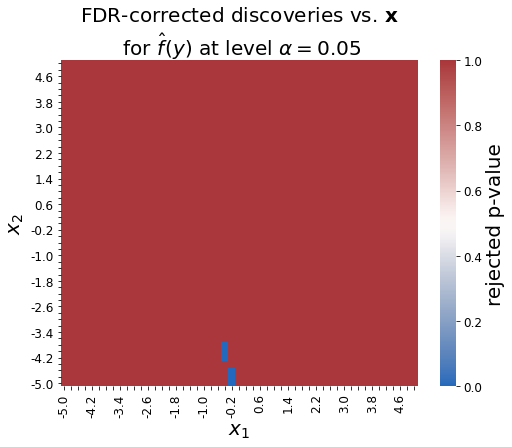

In [450]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_marg.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)